In [3]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Clustering Algorithms

## Table of Contents

* Making up data (code needs to be run to, but don't worry about the code here)
* [Intro Data EDA](#Intro-Data-EDA)
    * `TODO: write high level notes here`
    
    
* [KMeans](#KMeans)
    * Change `k` (sklearn calls it `n_clusters`) to get different results
    * Good for only continuous numeric data
    * Must specify k
    * Easy to interpret/fast
    * Sensitive to outliers
    * Only good with isotropic clusters
    * Can handle large data sets
    
    
* [kmedoids](#kmedoids)
    * Change `k` (sklearn calls it `n_clusters`) to get different results
    * Change initial medoids to (possibly) change results
    * Not as sensitive to outliers
    * Slower than kmeans
    * Must specify k
    * Interpretation - centers are actual points
    * Mixed data types - distance matrix
    
    
* [AgglomerativeClustering](#AgglomerativeClustering)
    * Linkage types:
        * single (take min dist when merging clusters): biased towards producing 'global' larger clusters
        * average (take avg dist ....: similarish to complete
        * complete (take max dist ....): biased towards producing 'local', smaller clusters
        * ward (only applicable to euclidean): works kind of like a centroid
    * You can specify `k` but don't have to
    * Can cut dendrogram at distance threshold
    * Visualize with a dendrogram
    * Flexible with linkage types
    * Slow/Not Scalable
    * Mixed data types
    
    
* [DBSCAN](#DBSCAN)
    * eps: large eps will bias towards a single huge cluster
    * min_samples: larger min_samples will lead to more points being marked as outliers
    * Good with atypical shaped data
    * Sensitive to parameters
    * Identify and label outliers (handles noise)
    * Don't have to specify k
    * Mixed data types
    
    
* [GaussianMixture](#GaussianMixture)
    * Change `n_clusters` to get different amount of clusters
    * Assumes multiple normal distributions
    * You can get probabilites (soft method)
    * Flexibility in changing `covariance` types "full", "tied", "diag", "spherical"
    * Have to specify k
    * Only works with numerical data
    * Doesn't scale well with high dimensions
    
    
* [MeanShift](#MeanShift)
    * `bandwidth` and end up with 1 mega cluster
    * fewer hyper-params
    * bandwidth is very sensitive
    * atypically shaped clusters
    * robust to outliers
    * not good for categorical data
    * Slow in high dimension
    
    
* [AffinityPropagation](#AffinityPropagation)
    * `preference` too high and end up with all points being their own cluster
    * Conceptually challenging
    * Can use multiple types of distances
    * Atypical cluster shapes
    * Very slow
    * Cluster centers (exemplars) are real points
    
    

In [22]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import pdist, squareform

# !pip install pyclustering
from pyclustering.cluster.kmedoids import kmedoids

from sklearn.cluster import (
    KMeans,
    DBSCAN,
    AgglomerativeClustering,
    AffinityPropagation,
    MeanShift,
)
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale
from sklearn import metrics

from gower import gower_matrix

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [5]:
def plot_cluster_results(X, labels):
    """Plot a 2d X (first 2 columns will be used) colored by label"""
    # Ensure X is a dataframe with 2 columns named x1 & x2
    df_x = pd.DataFrame(X)
    df_x = df_x.iloc[:, :2]
    df_x.columns = ["x1", "x2"]

    df_x["label"] = labels
    df_x = df_x.sort_values("label")
    # Make seaborn not convert the labels to numeric
    df_x["label"] = "'" + df_x["label"].astype(str) + "'"

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.scatterplot("x1", "x2", data=df_x, ax=axes[0])
    sns.scatterplot("x1", "x2", hue="label", data=df_x, ax=axes[1])
    axes[0].set_title("input data")
    axes[1].set_title("labeled data")
    plt.tight_layout()

<IPython.core.display.Javascript object>

## Making up example data

[back to top](#Clustering-Algorithms)

* `df_1` - numbers only
* `df_2` - numbers only
* `df_3` - yes/no survey style data
* `df_4` - nominal style data with all features having >3 category levels
* `df_5` - `df_1` + `df_3` + `df_4`

Click link to scroll on down to [Intro Data EDA](#Intro-Data-EDA).

----

In [6]:
n = 5000

<IPython.core.display.Javascript object>

Make up some purely numeric data

In [7]:
def make_df_1_2():
    np.random.seed(4)
    X1, _ = make_blobs(n, centers=5)

    np.random.seed(1)
    X2, _ = make_blobs(n, centers=5)

    df_1 = pd.DataFrame(scale(X1), columns=["x1", "x2"])
    df_2 = pd.DataFrame(scale(X2), columns=["x1", "x2"])

    return df_1, df_2

<IPython.core.display.Javascript object>

Make up some binary data

In [8]:
def make_df_3():
    np.random.seed(42)

    df_3 = pd.DataFrame()
    for i in range(5):
        col_name = f"q{i + 1}"
        df_3[col_name] = np.random.choice([0, 1], size=n)

    row_filter = df_3["q1"] == 1
    df_3.loc[row_filter, "q5"] = np.random.choice(
        [0, 1], size=sum(row_filter), p=[0.9, 0.1]
    )

    row_filter = df_3["q2"] == 1
    df_3.loc[row_filter, "q4"] = np.random.choice(
        [0, 1], size=sum(row_filter), p=[0.1, 0.9]
    )

    return df_3

<IPython.core.display.Javascript object>

Make up some categorical data

In [9]:
def make_df_4():
    np.random.seed(42)

    continents = [
        "Africa",
        "Asia",
        "Europe",
        "South America",
    ]

    dept = ["Accounting", "Sales", "IT", "Marketing"]
    companies = ["Innovato", "Rop", "UpDog"]

    df_4 = pd.DataFrame(
        {
            "continent": np.random.choice(continents, size=n),
            "dept": np.random.choice(dept, size=n),
        }
    )
    df_4["company"] = np.nan

    continent_filter = df_4["continent"].isin(continents[:2])
    df_4.loc[continent_filter, "company"] = np.random.choice(
        companies, p=[0.5, 0.3, 0.2], size=sum(continent_filter)
    )

    continent_filter = df_4["continent"].isin(continents[2:])
    df_4.loc[continent_filter, "company"] = np.random.choice(
        companies, p=[0.2, 0.3, 0.5], size=sum(continent_filter)
    )

    return df_4

<IPython.core.display.Javascript object>

Combine made up data to have mixed datatypes.

In [10]:
def make_df_5():
    df_1, _ = make_df_1_2()
    df_3 = make_df_3()
    df_4 = make_df_4()
    df_5 = pd.concat((df_1, df_3, df_4), axis=1)

    return df_5

<IPython.core.display.Javascript object>

## Intro Data EDA

[back to top](#Clustering-Algorithms)

In [11]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1` and `df_2` each consist of 2 numeric features.

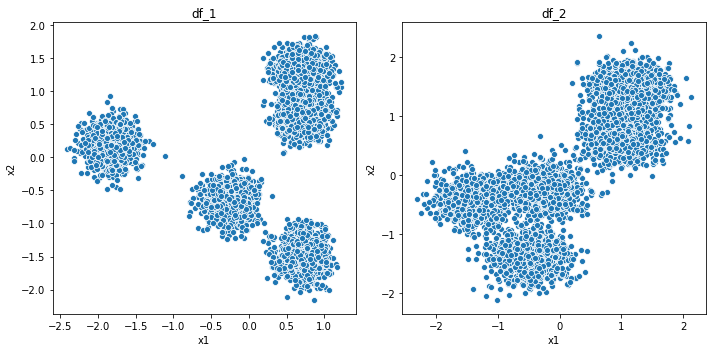

<IPython.core.display.Javascript object>

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot("x1", "x2", data=df_1, ax=axes[0])
sns.scatterplot("x1", "x2", data=df_2, ax=axes[1])
axes[0].set_title("df_1")
axes[1].set_title("df_2")
plt.tight_layout()
plt.show()

`df_3` is binary data representing True/False responses to a survey

In [13]:
# Co-occurance matrix

# Read as how many times the question in
# the column was True at the same time the
# row question was True

# The diagonal represents how many times the question
# was answered as True

# For example, we can see q4 was the question was
# likely answered as True

# For example, q2 and q4 were commonly answered as True together
# 2222 times (44% of responses) is the highest off-diagonal number

# For example, q1 and q5 were rarely answered as True together
# 246 times (5% of responses) is the lowest number

co_occur = df_3.T.dot(df_3)
co_occur_percent = co_occur / df_3.shape[0]

print("Co-occurances")
display(co_occur.style.background_gradient(axis=None))

print("Co-occurances as a percent of responses")
display(co_occur_percent.style.background_gradient(axis=None))

Co-occurances


,q1,q2,q3,q4,q5
q1,2496,1186,1245,1730,246
q2,1186,2491,1240,2222,781
q3,1245,1240,2492,1723,748
q4,1730,2222,1723,3493,1059
q5,246,781,748,1059,1516


Co-occurances as a percent of responses


,q1,q2,q3,q4,q5
q1,0.499200,0.237200,0.249000,0.346000,0.049200
q2,0.237200,0.498200,0.248000,0.444400,0.156200
q3,0.249000,0.248000,0.498400,0.344600,0.149600
q4,0.346000,0.444400,0.344600,0.698600,0.211800
q5,0.049200,0.156200,0.149600,0.211800,0.303200


<IPython.core.display.Javascript object>

`df_4` is categorical data

In [14]:
# Again, co-occurances

# We see Innovato seems to be more associated with Africa and Asia
# We see UpDog is associated with Europe and South America

crosstab = pd.crosstab([df_4["company"], df_4["continent"]], df_4["dept"])
crosstab.style.background_gradient(axis=None)

<IPython.core.display.Javascript object>

`df_5` is a combination of `df_1`, `df_3`, and `df_4`.

In [15]:
df_5.head()

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
0,0.828952,-1.287727,0,0,0,1,0,Europe,IT,UpDog
1,-2.068668,-0.025076,1,0,1,1,0,South America,IT,UpDog
2,-0.466015,-0.515344,0,0,0,1,1,Africa,IT,Innovato
3,0.505617,1.020197,0,0,1,0,1,Europe,IT,Rop
4,0.234860,-1.424100,0,1,1,1,0,Europe,Marketing,Rop


<IPython.core.display.Javascript object>

## KMeans

[back to top](#Clustering-Algorithms)

In [24]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1`

In [25]:
df_1.head(3)

,x1,x2
0,0.828952,-1.287727
1,-2.068668,-0.025076
2,-0.466015,-0.515344


<IPython.core.display.Javascript object>

In [49]:
clst = KMeans(10)
clst.fit(df_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<IPython.core.display.Javascript object>

In [50]:
clst.cluster_centers_

array([[-0.2816856 , -0.82440505],
       [ 0.5913511 ,  1.21703081],
       [-1.78399668,  0.34432064],
       [ 0.68485063, -1.31565553],
       [ 0.67155514,  0.49724115],
       [ 0.72044022,  0.81304679],
       [-1.86878048,  0.03817357],
       [ 0.72983687, -1.63837439],
       [ 0.76990014,  1.44282925],
       [-0.24179428, -0.50893463]])

<IPython.core.display.Javascript object>

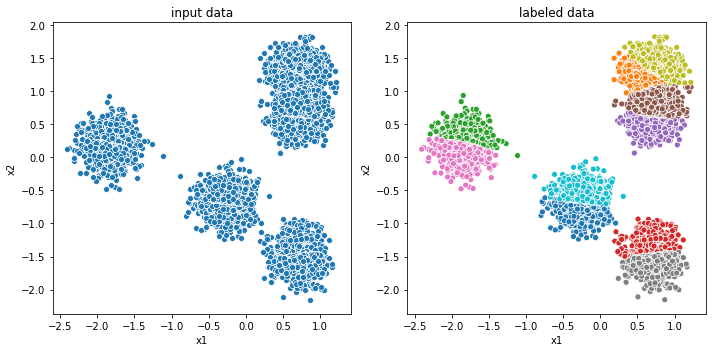

<IPython.core.display.Javascript object>

In [51]:
labels = clst.labels_

plot_cluster_results(df_1, labels)
plt.legend().remove()
plt.show()

In [52]:
metrics.davies_bouldin_score(df_1, labels)

1.1647077395534988

<IPython.core.display.Javascript object>

In [53]:
metrics.silhouette_score(df_1, labels)

0.31946681485211836

<IPython.core.display.Javascript object>

In [54]:
clst.inertia_

213.69264407999646

<IPython.core.display.Javascript object>

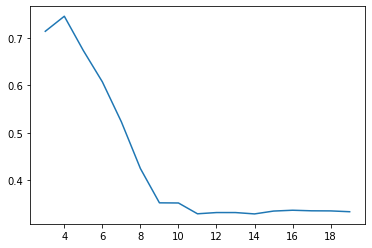

<IPython.core.display.Javascript object>

In [56]:
sil_scores = []
for k in range(3, 20):
    clst = KMeans(k)
    clst.fit(df_1)
    sil_score = metrics.silhouette_score(df_1, clst.labels_)
    sil_scores.append(sil_score)

plt.plot(range(3, 20), sil_scores)

`df_2`

In [41]:
clst = KMeans(5)
clst.fit(df_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<IPython.core.display.Javascript object>

In [42]:
clst.cluster_centers_

array([[-0.25679555, -0.25427167],
       [ 1.14229696,  1.45972791],
       [-1.3979286 , -0.44773243],
       [-0.48666025, -1.39980594],
       [ 1.00230001,  0.62977222]])

<IPython.core.display.Javascript object>

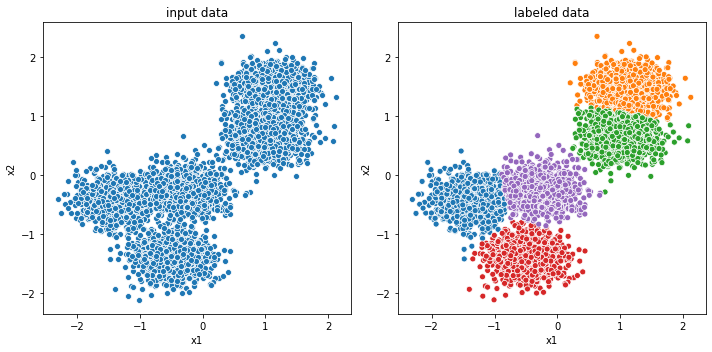

<IPython.core.display.Javascript object>

In [21]:
labels = clst.labels_

plot_cluster_results(df_2, labels)
plt.legend().remove()
plt.show()

`df_3`

In [22]:
df_3.head(3)

,q1,q2,q3,q4,q5
0,0,0,0,1,0
1,1,0,1,1,0
2,0,0,0,1,1


<IPython.core.display.Javascript object>

In [23]:
# Nope

<IPython.core.display.Javascript object>

`df_4`

In [24]:
df_4.head(3)

,continent,dept,company
0,Europe,IT,UpDog
1,South America,IT,UpDog
2,Africa,IT,Innovato


<IPython.core.display.Javascript object>

In [25]:
# Nope

<IPython.core.display.Javascript object>

`df_5`

In [26]:
df_5.head(3)

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
0,0.828952,-1.287727,0,0,0,1,0,Europe,IT,UpDog
1,-2.068668,-0.025076,1,0,1,1,0,South America,IT,UpDog
2,-0.466015,-0.515344,0,0,0,1,1,Africa,IT,Innovato


<IPython.core.display.Javascript object>

In [27]:
# Nope

<IPython.core.display.Javascript object>

## kmedoids

[back to top](#Clustering-Algorithms)

In [28]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1`

In [29]:
df_1.head(3)

,x1,x2
0,0.828952,-1.287727
1,-2.068668,-0.025076
2,-0.466015,-0.515344


<IPython.core.display.Javascript object>

In [30]:
labels = _____

plot_cluster_results(df_1, labels)
plt.legend().remove()
plt.show()

NameError: name '_____' is not defined

<IPython.core.display.Javascript object>

`df_2`

In [ ]:
df_2.head(3)

In [ ]:
labels = _____

plot_cluster_results(df_2, labels)
plt.legend().remove()
plt.show()

`df_3`

In [ ]:
df_3.head(3)

`df_4`

In [ ]:
df_4.head(3)

`df_5`

In [ ]:
df_5.head(3)

## AgglomerativeClustering

[back to top](#Clustering-Algorithms)

In [ ]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

`df_1`

In [ ]:
df_1.head(3)

In [ ]:
labels = _____

plot_cluster_results(df_1, labels)
plt.legend().remove()
plt.show()

`df_2`

In [ ]:
df_2.head(3)

In [ ]:
labels = _____

plot_cluster_results(df_2, labels)
plt.legend().remove()
plt.show()

`df_3`

In [ ]:
df_3.head(3)

`df_4`

In [ ]:
df_4.head(3)

`df_5`

In [ ]:
df_5.head(3)

## DBSCAN

[back to top](#Clustering-Algorithms)

In [ ]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

`df_1`

In [ ]:
df_1.head(3)

In [ ]:
labels = _____

plot_cluster_results(df_1, labels)
plt.legend().remove()
plt.show()

`df_2`

In [ ]:
df_2.head(3)

In [ ]:
labels = _____

plot_cluster_results(df_2, labels)
plt.legend().remove()
plt.show()

`df_3`

In [ ]:
df_3.head(3)

`df_4`

In [ ]:
df_4.head(3)

`df_5`

In [ ]:
df_5.head(3)

## GaussianMixture

[back to top](#Clustering-Algorithms)

In [ ]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

`df_1`

In [ ]:
df_1.head(3)

In [ ]:
labels = _____

plot_cluster_results(df_1, labels)
plt.legend().remove()
plt.show()

`df_2`

In [ ]:
df_2.head(3)

In [ ]:
labels = _____

plot_cluster_results(df_2, labels)
plt.legend().remove()
plt.show()

`df_3`

In [ ]:
df_3.head(3)

`df_4`

In [ ]:
df_4.head(3)

`df_5`

In [ ]:
df_5.head(3)

## MeanShift

[back to top](#Clustering-Algorithms)

In [ ]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

`df_1`

In [ ]:
df_1.head(3)

In [ ]:
labels = _____

plot_cluster_results(df_1, labels)
plt.legend().remove()
plt.show()

`df_2`

In [ ]:
df_2.head(3)

In [ ]:
labels = _____

plot_cluster_results(df_2, labels)
plt.legend().remove()
plt.show()

`df_3`

In [ ]:
df_3.head(3)

`df_4`

In [ ]:
df_4.head(3)

`df_5`

In [ ]:
df_5.head(3)

## AffinityPropagation

[back to top](#Clustering-Algorithms)

In [31]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1`

In [32]:
df_1.head(3)

,x1,x2
0,0.828952,-1.287727
1,-2.068668,-0.025076
2,-0.466015,-0.515344


<IPython.core.display.Javascript object>

In [33]:
# Downsampling because its slow to fit to 5000 records
df_sample = df_1.sample(500, random_state=42)

clst = AffinityPropagation(preference=-7)
clst.fit(df_sample)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=-7, verbose=False)

<IPython.core.display.Javascript object>

In [34]:
df_sample.iloc[clst.cluster_centers_indices_, :]

,x1,x2
4615,0.700956,1.381985
3570,0.722910,-1.533595
4077,0.728771,0.747977
2727,-0.233554,-0.699712
4605,-1.833158,0.186318


<IPython.core.display.Javascript object>

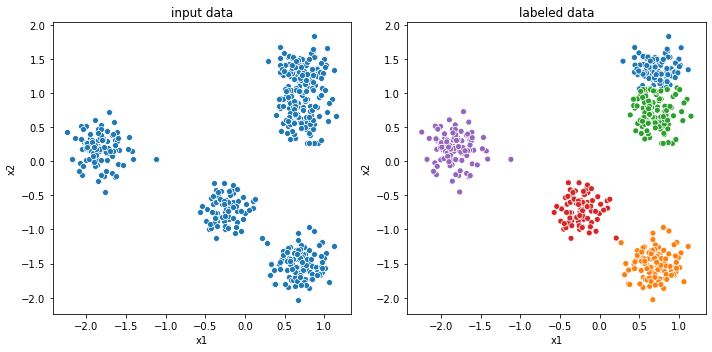

<IPython.core.display.Javascript object>

In [35]:
labels = clst.labels_

plot_cluster_results(df_sample, labels)
plt.legend().remove()
plt.show()

`df_2`

In [36]:
df_2.head(3)

,x1,x2
0,0.081766,-0.216337
1,1.368599,1.401082
2,1.612872,1.564719


<IPython.core.display.Javascript object>

In [37]:
# Downsampling because its slow to fit to 5000 records
df_sample = df_2.sample(500, random_state=42)

clst = AffinityPropagation()
clst.fit(df_sample)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None, verbose=False)

<IPython.core.display.Javascript object>

In [38]:
df_sample.iloc[clst.cluster_centers_indices_, :]

,x1,x2
1117,-0.094717,-0.417416
3906,1.228448,0.646609
3682,-1.211046,-0.251793
4256,0.939135,1.608963
3557,0.025241,-1.574433
472,-0.391523,-0.205813
33,-0.452011,-1.521055
3918,-1.663386,-0.494168
1550,1.092605,1.310957
2809,-0.834063,-1.424049


<IPython.core.display.Javascript object>

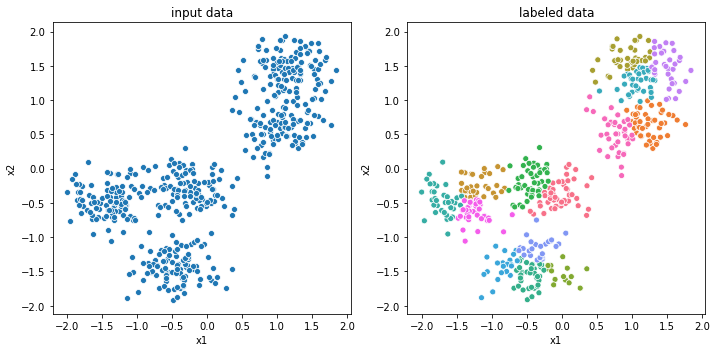

<IPython.core.display.Javascript object>

In [39]:
labels = clst.labels_

plot_cluster_results(df_sample, labels)
plt.legend().remove()
plt.show()

`df_3`

In [40]:
df_3.head(3)

,q1,q2,q3,q4,q5
0,0,0,0,1,0
1,1,0,1,1,0
2,0,0,0,1,1


<IPython.core.display.Javascript object>

In [41]:
# Downsampling because its slow to fit to 5000 records
# Could not get algo to converge using a sample of 500
# Could not get algo to converge using a sample of 150
df_sample = df_3.sample(100, random_state=42)

dist_mat = squareform(pdist(df_sample, metric="hamming"))
affinity_mat = -dist_mat

clst = AffinityPropagation(
    affinity="precomputed", preference=affinity_mat.min() * 3, max_iter=10000,
)
clst.fit(affinity_mat)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=10000, preference=-3.0,
                    verbose=False)

<IPython.core.display.Javascript object>

In [42]:
df_sample.iloc[clst.cluster_centers_indices_, :]

,q1,q2,q3,q4,q5
3351,1,1,1,1,0
2515,1,0,0,0,0
3161,0,1,0,1,1
4183,0,0,1,1,0


<IPython.core.display.Javascript object>

In [43]:
# pip install scikit-learn --upgrade

<IPython.core.display.Javascript object>

In [44]:
import sklearn

sklearn.__version__


'0.22.1'

<IPython.core.display.Javascript object>

In [ ]:
labels = clst.labels_
uniq_labels = sorted(np.unique(labels))

for label in uniq_labels:
    df_i = df_sample[labels == label]

    print(f"Cluster {label} co-occuring True answers")
    co_occur = df_i.T.dot(df_i)
    display(co_occur.style.background_gradient())

`df_4`

In [45]:
df_4.head(3)

,continent,dept,company
0,Europe,IT,UpDog
1,South America,IT,UpDog
2,Africa,IT,Innovato


<IPython.core.display.Javascript object>

In [49]:
# Downsampling because its slow to fit to 5000 records
# Could not get algo to converge using a sample of 500
# Could not get algo to converge using a sample of 150
df_sample = df_4.sample(100, random_state=42)
df_sample_dummies = pd.get_dummies(df_sample)

dist_mat = squareform(pdist(df_sample_dummies, metric="dice"))
affinity_mat = -dist_mat

clst = AffinityPropagation(affinity="precomputed", preference=affinity_mat.min() * 4,)
clst.fit(affinity_mat)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=-4.0, verbose=False)

<IPython.core.display.Javascript object>

In [50]:
df_sample.iloc[clst.cluster_centers_indices_, :]

,continent,dept,company
4121,Europe,Accounting,Rop
1413,South America,Marketing,UpDog
157,Asia,IT,Innovato
4740,Africa,Sales,Innovato


<IPython.core.display.Javascript object>

In [51]:
labels = clst.labels_
uniq_labels = sorted(np.unique(labels))

for label in uniq_labels:
    df_i = df_sample[labels == label]

    print(f"Cluster {label} co-occuring categories")
    crosstab = pd.crosstab([df_i["company"], df_i["continent"]], df_i["dept"])
    display(crosstab.style.background_gradient(axis=None))

Cluster 0 co-occuring categories


Cluster 1 co-occuring categories


Cluster 2 co-occuring categories


Cluster 3 co-occuring categories


<IPython.core.display.Javascript object>

`df_5`

In [52]:
df_5.head(3)

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
0,0.828952,-1.287727,0,0,0,1,0,Europe,IT,UpDog
1,-2.068668,-0.025076,1,0,1,1,0,South America,IT,UpDog
2,-0.466015,-0.515344,0,0,0,1,1,Africa,IT,Innovato


<IPython.core.display.Javascript object>

In [54]:
# Computing a distance matrix of 5000 * 5000 is a lot
df_sample = df_5.sample(500, random_state=42)
dist_mat = gower_matrix(df_sample)

affinity_mat = -dist_mat

clst = AffinityPropagation(
    affinity="precomputed", preference=affinity_mat.min() * 5, max_iter=5000,
)
clst.fit(affinity_mat)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=5000, preference=-4.7333866357803345,
                    verbose=False)

<IPython.core.display.Javascript object>

In [55]:
df_sample.iloc[clst.cluster_centers_indices_, :]

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
3181,0.772538,0.650680,0,1,1,1,0,Europe,Marketing,UpDog
3525,0.541429,0.586474,0,1,0,1,0,Africa,Sales,Innovato
4595,0.456863,0.446442,1,1,0,1,0,South America,Marketing,UpDog
4264,0.482000,1.269947,0,0,1,0,1,Africa,IT,Innovato
3106,0.630786,0.866244,1,0,1,1,0,Asia,IT,Innovato
2836,0.824800,0.685079,1,1,1,1,0,Asia,Sales,Rop
2053,-0.234409,-0.630190,1,0,1,0,0,South America,Accounting,Rop
4686,-0.237691,-0.570702,0,0,0,0,0,Europe,IT,UpDog
889,-0.304057,-0.434887,0,0,0,1,1,Africa,Accounting,Rop


<IPython.core.display.Javascript object>